In [87]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer

In [89]:
test_component = pd.read_csv("test_components_contexts.csv")
train_component = pd.read_csv("train_components_contexts.csv")
validation_component = pd.read_csv("validation_components_contexts.csv")

test_component.head()

,Year,Date,SectionID,ID,SpeechID,Label,Text,Start,End,SentenceID_begin,SentenceID_end,Current_Sentence,Previous_Sentence,Next_Sentence,Speaker,context1,context2
0,1960,21Oct,6,T289,2,Premise,the conditions I laid out in one of our previo...,429,496,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
1,1960,21Oct,6,T290,2,Premise,it's rather difficult to be much more specific...,502,558,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
2,1960,21Oct,6,T291,2,Claim,we have to have adequate preparation for a sum...,579,639,1,1,"Uh - First of all, we have to have adequate pr...",NIXON: Well the conditions I laid out in one o...,This means at the secretary of state level and...,NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
3,1960,21Oct,6,T292,2,Premise,This means at the secretary of state level and...,641,714,2,2,This means at the secretary of state level and...,"Uh - First of all, we have to have adequate pr...",By adequate preparation I mean that at that le...,NIXON,"Uh - First of all, we have to have adequate pr...",Well the conditions I laid out in one of our ...
4,1960,21Oct,6,T293,2,Premise,By adequate preparation I mean that at that le...,716,863,3,3,By adequate preparation I mean that at that le...,This means at the secretary of state level and...,Now this agenda should delineate those issues ...,NIXON,This means at the secretary of state level and...,Well the conditions I laid out in one of our ...


In [90]:
# merge data
all_data = pd.concat([test_component, train_component, validation_component])

all_data.head()

,Year,Date,SectionID,ID,SpeechID,Label,Text,Start,End,SentenceID_begin,SentenceID_end,Current_Sentence,Previous_Sentence,Next_Sentence,Speaker,context1,context2
0,1960,21Oct,6,T289,2,Premise,the conditions I laid out in one of our previo...,429,496,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
1,1960,21Oct,6,T290,2,Premise,it's rather difficult to be much more specific...,502,558,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
2,1960,21Oct,6,T291,2,Claim,we have to have adequate preparation for a sum...,579,639,1,1,"Uh - First of all, we have to have adequate pr...",NIXON: Well the conditions I laid out in one o...,This means at the secretary of state level and...,NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
3,1960,21Oct,6,T292,2,Premise,This means at the secretary of state level and...,641,714,2,2,This means at the secretary of state level and...,"Uh - First of all, we have to have adequate pr...",By adequate preparation I mean that at that le...,NIXON,"Uh - First of all, we have to have adequate pr...",Well the conditions I laid out in one of our ...
4,1960,21Oct,6,T293,2,Premise,By adequate preparation I mean that at that le...,716,863,3,3,By adequate preparation I mean that at that le...,This means at the secretary of state level and...,Now this agenda should delineate those issues ...,NIXON,This means at the secretary of state level and...,Well the conditions I laid out in one of our ...


In [91]:
# remove all the null context
print(len(all_data))
all_data = all_data[all_data['context1'].notnull()]
print(len(all_data))
# reduce size of the dataset to reduce the time to process
all_data = all_data.sample(n=int(len(all_data)/2)).sort_index()
print(len(all_data))


32988
32748
16374


In [92]:
# drop la classe Question car trop peu signifiante dans le dataset
all_data = all_data[all_data['Label'] != 'Question']

#get unique values of label (our class for the classification)
classes = all_data['Label'].unique()

In [93]:
# convert label to class
all_data.Label = pd.Categorical(all_data.Label)
all_data['label_code'] = all_data.Label.cat.codes


In [94]:
# for the experience we only keep column context1 and label code
all_data = all_data[['Text', 'label_code']]

In [95]:

# split into train, test and validation samples (60% , 20% and 20%)
train, validation, test = np.split(all_data.sample(frac=0.4, random_state=42), [int(.2*len(all_data)), int(.3*len(all_data))])

print(len(train))
print(len(validation))
print(len(test))

3268
1634
1635


### Source
https://www.intodeeplearning.com/bert-multiclass-text-classification/

In [96]:
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [97]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks


In [98]:
train_input_ids, train_att_masks = encode(train['Text'].values.tolist())
valid_input_ids, valid_att_masks = encode(validation['Text'].values.tolist())
test_input_ids, test_att_masks = encode(test['Text'].values.tolist())


In [99]:
import torch
train_y = torch.LongTensor(train['label_code'].values.tolist())
valid_y = torch.LongTensor(validation['label_code'].values.tolist())
test_y = torch.LongTensor(test['label_code'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()


(torch.Size([3268]), torch.Size([1634]), torch.Size([1635]))

In [100]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [101]:
from transformers import BertForSequenceClassification
N_labels = len(train.label_code.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [103]:
model = model.cuda()


In [104]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6
# LEARNING_RATE = 1e-3

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )


In [105]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(validation) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.6542477860683348 
103/103 val loss: 0.6083184335995646 
Epoch:  2


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.5906153520432914 
103/103 val loss: 0.5886107538510295 
Epoch:  3


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.5648133382564637 
103/103 val loss: 0.5859835836493853 
Epoch:  4


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.5313728713407749 
103/103 val loss: 0.5778011118324058 
Epoch:  5


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.5130911612656058 
103/103 val loss: 0.5764149379672356 
Epoch:  6


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.49509065674572456 
103/103 val loss: 0.586841863335915 
Epoch:  7


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.46694550063551926 
103/103 val loss: 0.586399117141094 
Epoch:  8


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.45087298547349325 
103/103 val loss: 0.5917462158260993 
Epoch:  9


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.42190145639384663 
103/103 val loss: 0.6004051515488948 
Epoch:  10


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.40662960991626834 
103/103 val loss: 0.6138157630429685 
Epoch:  11


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.39134727018635446 
103/103 val loss: 0.6148270834418177 
Epoch:  12


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.36457066982984543 
103/103 val loss: 0.640335836022803 
Epoch:  13


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.35205944213198453 
103/103 val loss: 0.6457672093099761 
Epoch:  14


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.3286163923217029 
103/103 val loss: 0.6682467868605864 
Epoch:  15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.31833241958080266 
103/103 val loss: 0.6869116114470565 
Epoch:  16


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.3099510958281959 
103/103 val loss: 0.6932618418364849 
Epoch:  17


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2984290929102316 
103/103 val loss: 0.7059444498668597 
Epoch:  18


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.28456767399500055 
103/103 val loss: 0.7182198839569555 
Epoch:  19


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.27798677008689904 
103/103 val loss: 0.7310022283526301 
Epoch:  20


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2651089677178278 
103/103 val loss: 0.7400844839302082 
Epoch:  21


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.26639086118922 
103/103 val loss: 0.7497894214194956 
Epoch:  22


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.24577335611712642 
103/103 val loss: 0.7651178182907474 
Epoch:  23


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2374612025007969 
103/103 val loss: 0.7742816959191294 
Epoch:  24


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.23459022841075572 
103/103 val loss: 0.7846967745753168 
Epoch:  25


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.24380541358415672 
103/103 val loss: 0.7940282500484614 
Epoch:  26


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.22975312017086075 
103/103 val loss: 0.7977424425986207 
Epoch:  27


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.21500286676171348 
103/103 val loss: 0.8066273603624511 
Epoch:  28


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2231522805080181 
103/103 val loss: 0.8079353938403638 
Epoch:  29


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.21667478420748942 
103/103 val loss: 0.8098001138677875 
Epoch:  30


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2236735352110572 
103/103 val loss: 0.810479106254948 


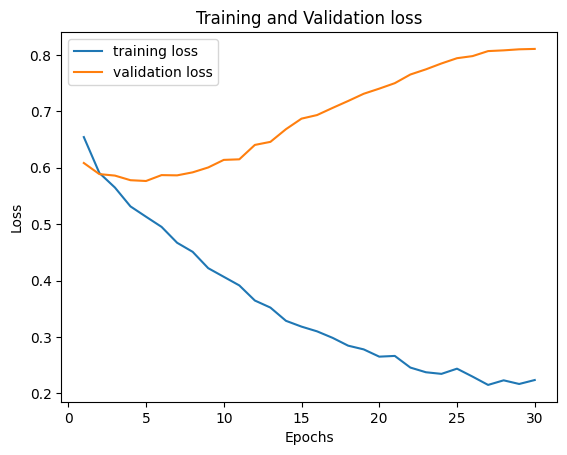

In [106]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


In [107]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, validation['label_code'].to_numpy(), target_names=classes))


classifiation report
              precision    recall  f1-score   support

       Claim       0.75      0.71      0.73       871
     Premise       0.69      0.72      0.70       763

    accuracy                           0.72      1634
   macro avg       0.72      0.72      0.72      1634
weighted avg       0.72      0.72      0.72      1634



In [108]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()


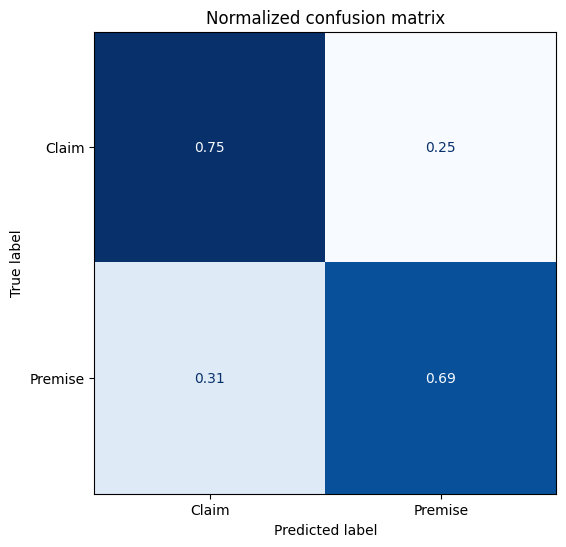

In [109]:
plot_confusion_matrix(valid_pred,validation['label_code'].to_numpy(),labels=classes)


In [110]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)


0it [00:00, ?it/s]

In [111]:
print('classifiation report')
print(classification_report(test_pred, test['label_code'].to_numpy(),target_names=classes))


classifiation report
              precision    recall  f1-score   support

       Claim       0.73      0.67      0.70       902
     Premise       0.63      0.70      0.66       733

    accuracy                           0.68      1635
   macro avg       0.68      0.68      0.68      1635
weighted avg       0.68      0.68      0.68      1635



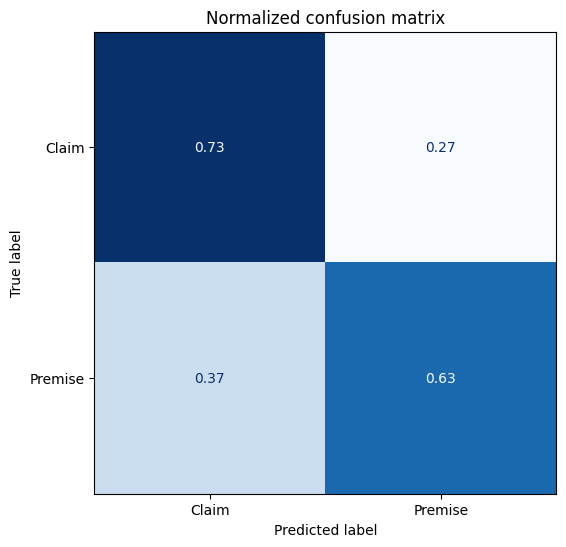

In [112]:
plot_confusion_matrix(test_pred,test['label_code'].to_numpy(),labels=classes)

In [113]:
# print misclassified component
test['pred'] = test_pred
test.reset_index(level=0)
print(test[test['label_code']!=test['pred']].shape)
test[test['label_code']!=test['pred']][['Text','label_code','pred']].head(10)

(524, 3)


,Text,label_code,pred
8694,the work that we've done with respect to sanct...,1,0
4266,I'll be happy to make shoes,1,0
6741,We shut the loophole which has American worker...,1,0
4321,They think the only way to do it is for the fe...,1,0
5931,natural gas production is up,0,1
3124,"they reported federal taxes, state and local t...",1,0
12699,I was honored to speak to those troops,1,0
799,We have built more schools in these last seven...,0,1
13177,"because of the problems in North Korea, we are...",1,0
9186,It's not the government's money,1,0
